# Extraction and exploration of Cognite OID

Sensor name    Frame length   First period length [s]  First timestamp
PDT-92534      (80790, 1)     30.0                     2018-11-01 00:00:00
PT-92523       (80786, 1)     30.0                     2018-11-01 00:00:00
TIC-92504      (80757, 1)     30.0                     2018-11-01 00:00:00
TT 92532       (74868, 1)     30.0                     2018-11-01 00:00:00
FT-92537       (80920, 1)     30.0                     2018-11-01 00:00:00
TT-92539       (75647, 1)     30.0                     2018-11-01 00:00:00
PT-92539       (80782, 1)     30.0                     2018-11-01 00:00:00
ZT 92543       (78333, 1)     30.0                     2018-11-01 00:00:00
KA 9101        (80659, 1)     30.0                     2018-11-01 00:00:00


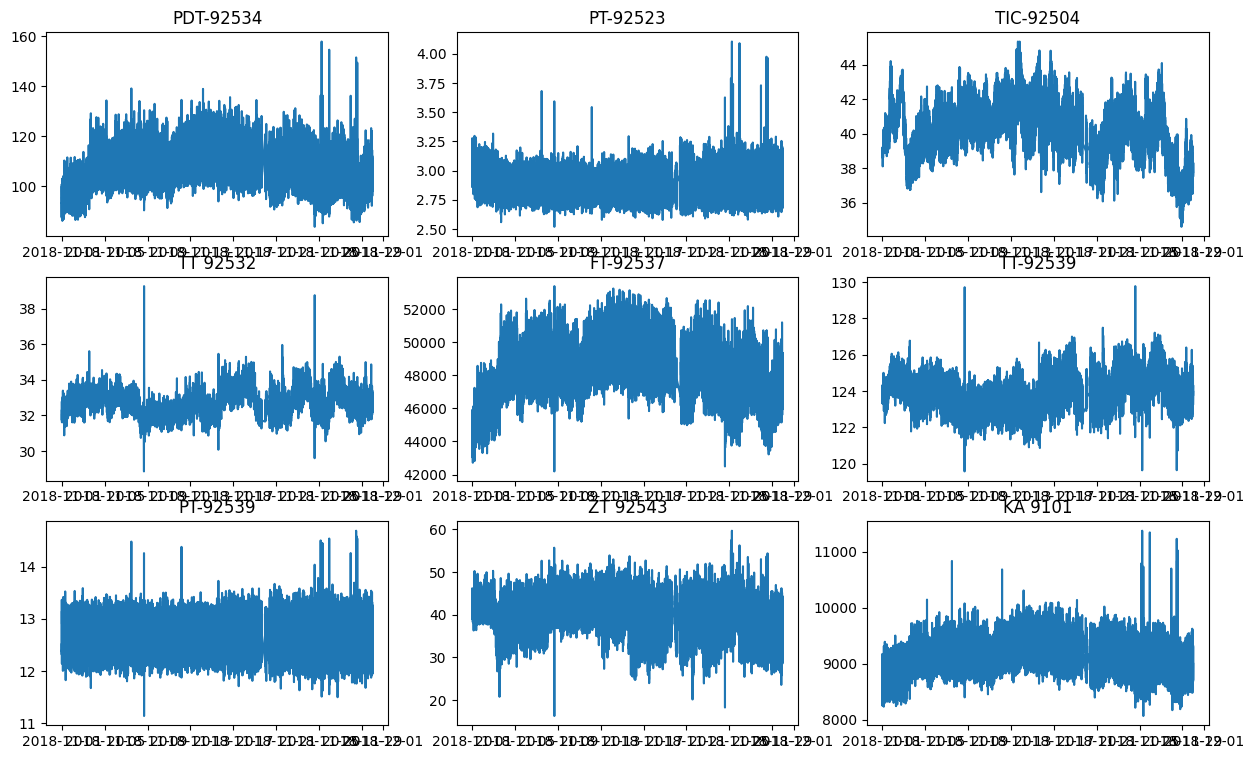

In [46]:
from publicdata import client as c
from functions import *
from datetime import datetime, timezone
import matplotlib.pyplot as plt
import pandas as pd
# %matplotlib widget  #Uncomment to make zoomable plot

# Nine sensors related to the inputs, outputs and controls of a compressor subsystem.
# Dictionary made with key=name of sensor and value=Id of sensor
sensors = {
    'PDT-92534': 6908033636680653,
    'PT-92523':8877482139815959,
    'TIC-92504':7012228881452176,
    'TT 92532':8152209984966682,
    'FT-92537':3278479880462408,
    'TT-92539':643849686863640,
    'PT-92539':1890487216163163,
    'ZT 92543':4146236330407219,
    'KA 9101':844472910348820
}
# I'll extract a pandas dataframe for each of the sensors in sensor_names, and these will be stored
# in the following dictionary, again with the sensor name as the key.
dfs_dict = {}

startdate = datetime(2018, 11, 1, tzinfo=timezone.utc)
enddate = datetime(2018, 11, 30, tzinfo=timezone.utc)
today = datetime.today()
# today = today.replace(hour=0, minute=0, second=0, microsecond=0)
# print(f'Today: {today}')
# print(f'Startdate: {startdate}')
# print(f'Enddate: {enddate}')
# days_since_start = (today - startdate).days
# days_since_end = (today - enddate).days
# starttime = f'{days_since_start}d-ago' # Start time of the interval I want to extract
# endtime = f'{days_since_end}d-ago' # End time of the interval I want to extract

print("Sensor name".ljust(15) + "Frame length".ljust(15) + "First period length [s]".ljust(25) + "First timestamp".ljust(15))

# Extract dataframes from Cognite OID and store them in the dfs_dict dictionary
for k, v in sensors.items():
    res = c.time_series.data.retrieve_dataframe(id=v, 
                                                start=startdate, 
                                                end=enddate, 
                                                column_names='id',
                                                aggregates=["average"],
                                                granularity="30s",)
    # Need to find a way to grab the unit of the time-series
    dfs_dict[k] = res
    sr = (res.index[1] - res.index[0]).total_seconds()
    # print(f'{k}\'s shape: {res.shape} and sampling frequency: {sr} second(s)')
    print(str(k).ljust(15) + str(res.shape).ljust(15) + str(sr).ljust(25) + str(res.index[0]).ljust(15))



# plot_sensor_data('PT-92523', dfs_dict)
plot_all_nine_sensors(dfs_dict)


### Simple inspection of the data

In [47]:
# print((dfs_dict["ZT 92543"].index[1] - dfs_dict["ZT 92543"].index[0]).total_seconds())

print("Name".ljust(12) + "First period".ljust(15) + "Second period".ljust(15) + "Third period".ljust(15) + "Average period".ljust(15))
for name, df in dfs_dict.items():
    f_per = (df.index[1] - df.index[0]).total_seconds()
    second_per = (df.index[2] - df.index[1]).total_seconds()
    third_per = (df.index[3] - df.index[2]).total_seconds()
    avg_per = ((df.index[-1] - df.index[0])/df.shape[0]).total_seconds()
    print(name.ljust(12) + str(f_per).ljust(15) + str(second_per).ljust(15) + str(third_per).ljust(15) + str(avg_per).ljust(15))


Name        First period   Second period  Third period   Average period 
PDT-92534   30.0           30.0           30.0           31.013367      
PT-92523    30.0           30.0           30.0           31.014903      
TIC-92504   30.0           30.0           30.0           31.026041      
TT 92532    30.0           30.0           30.0           33.466501      
FT-92537    30.0           30.0           30.0           30.963544      
TT-92539    30.0           30.0           60.0           33.121868      
PT-92539    30.0           30.0           30.0           31.016439      
ZT 92543    30.0           30.0           30.0           31.986136      
KA 9101     30.0           30.0           30.0           31.063737      


### Standardizing the data

PDT-92534: Avg: 105.878650474138 Std: 6.118243336601775 Shape: (80790, 1)
PT-92523: Avg: 2.886066422100905 Std: 0.09305660472080415 Shape: (80786, 1)
TIC-92504: Avg: 40.090486989516904 Std: 1.5026304302548346 Shape: (80757, 1)
TT 92532: Avg: 32.79619874182309 Std: 0.7181966420966084 Shape: (74868, 1)
FT-92537: Avg: 47958.00787128076 Std: 1518.2406865273606 Shape: (80920, 1)
TT-92539: Avg: 124.08047764107948 Std: 0.9067626774259565 Shape: (75647, 1)
PT-92539: Avg: 12.693092887869566 Std: 0.2677624900252132 Shape: (80782, 1)
ZT 92543: Avg: 39.07635524669462 Std: 3.6026007850976685 Shape: (78333, 1)
KA 9101: Avg: 9095.286672241173 Std: 225.1454270001261 Shape: (80659, 1)


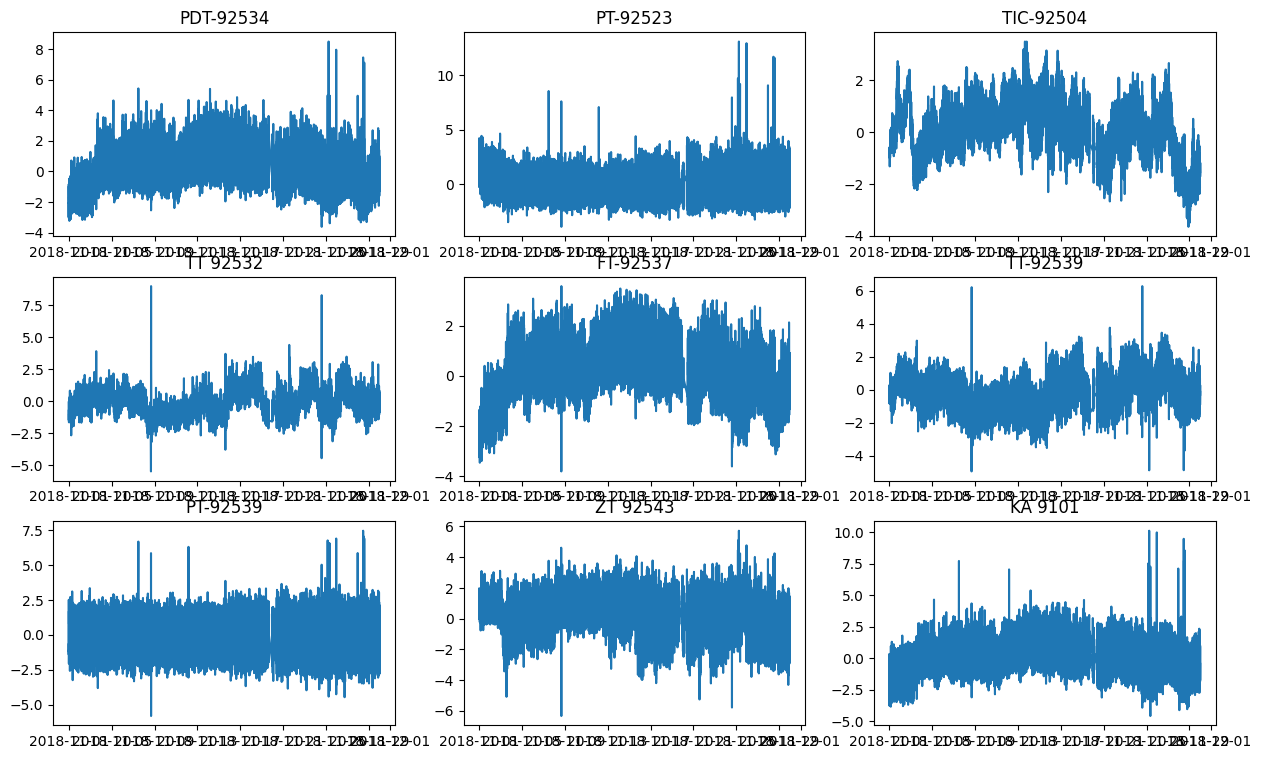

In [48]:
import numpy as np

standard_df = {}
# k = 6 #width of the range of accepted values

for name, df in dfs_dict.items():
    avg = df.mean().iloc[0]
    std = df.std().iloc[0]
    tmp_df = (df-avg)/std
    print(f'{name}: Avg: {avg} Std: {std} Shape: {tmp_df.shape}')

    # upper = k*std
    # lower = -k*std

    # # Create arrays of Boolean values indicating the outlier rows
    # upper_array = tmp_df.index[tmp_df[tmp_df.columns[0]] >= upper].tolist()
    # lower_array = tmp_df.index[tmp_df[tmp_df.columns[0]] <= lower].tolist()
    
    # # Removing the outliers
    # tmp_df.drop(index=upper_array, inplace=True)
    # tmp_df.drop(index=lower_array, inplace=True)
    
    # Print the new shape of the DataFrame
    # print("New Shape: ", tmp_df.shape)
    standard_df[name] = tmp_df

plot_all_nine_sensors(dataframe=standard_df)

### Compile and plot histograms for each sensor

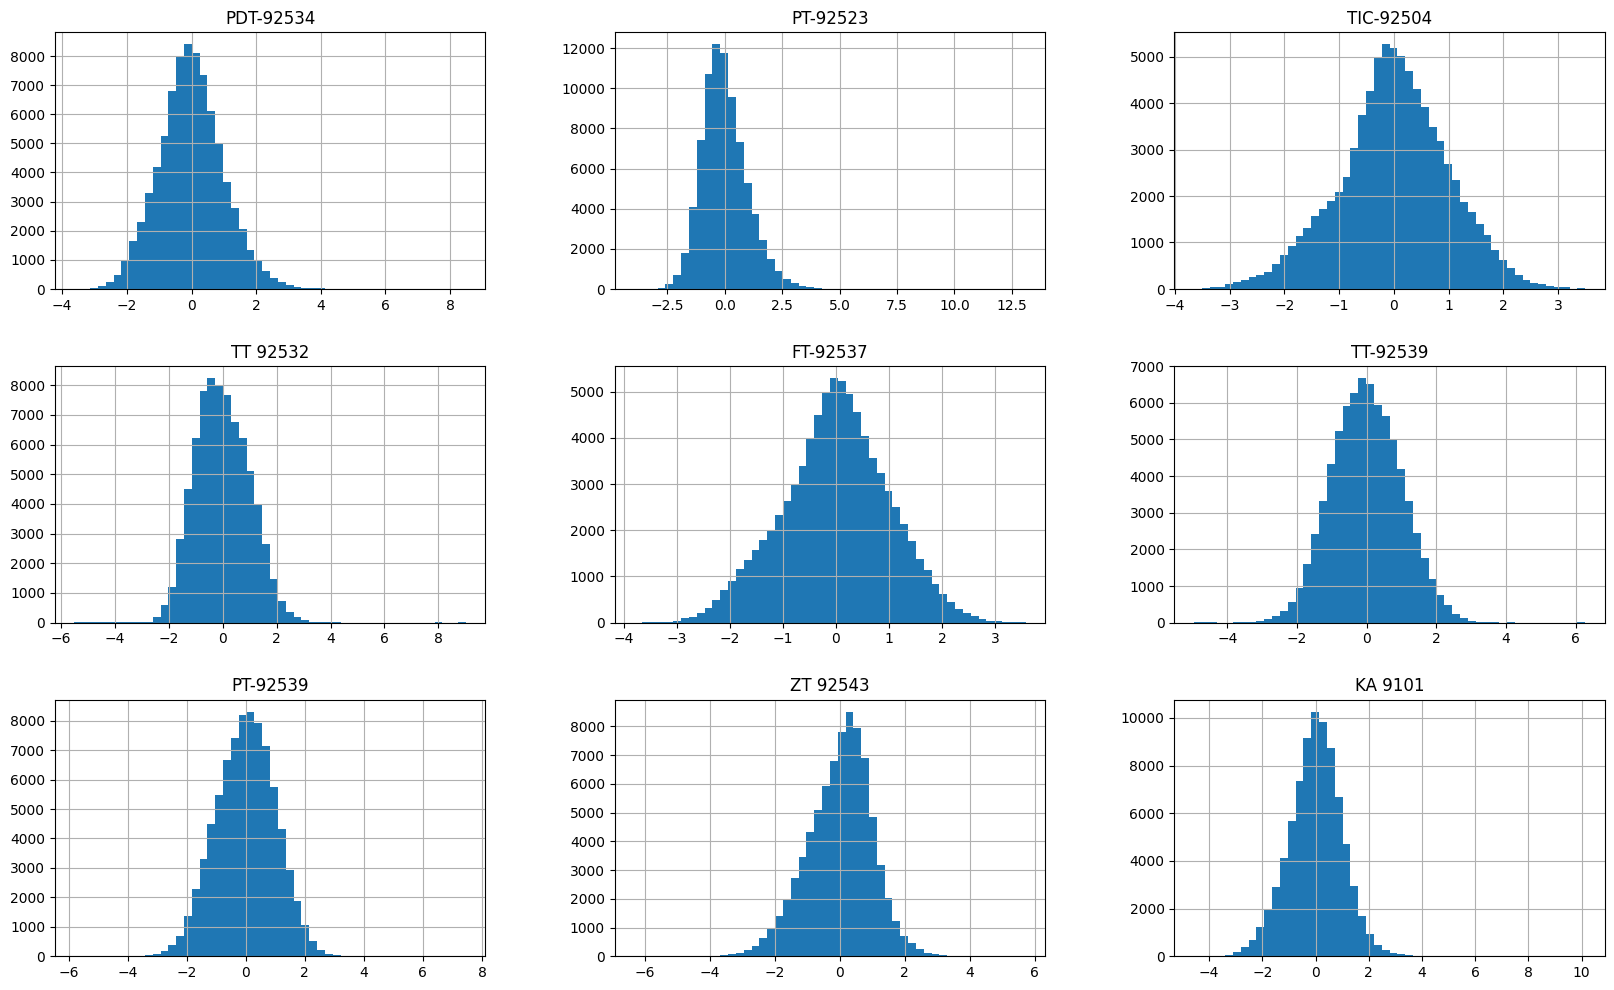

In [49]:
#Plot histograms
#Using standardized values
names = list(standard_df.keys())
fig, ax = plt.subplots(3, 3, figsize=(20, 12))
bins = 50

m=0
for i in range(3):
    for j in range(3):

        standard_df[names[m]].hist(bins = bins, ax=ax[i,j], figsize=(20, 18))
        ax[i,j].set_title(names[m])
        m+=1

plt.show()


### Finding KL divergence by comparing histograms

Note: you may need to restart the kernel to use updated packages.
[[0.0, inf, 1.3516055974117611, 0.9040452711246697, 1.4010837418619733, inf, inf, inf, inf], [inf, 0.0, 2.360979447540264, 3.0075847047270163, 2.498055020234914, inf, inf, inf, inf], [inf, inf, 0.0, 1.9697204582153094, 0.007356260713621524, inf, inf, inf, inf], [inf, inf, 0.8924523322585125, 0.0, 0.8853771585861623, inf, inf, inf, inf], [inf, inf, 0.0053936044202690745, 2.024790253970771, 0.0, inf, inf, inf, inf], [inf, inf, 0.32011303808716957, 0.4834691103438255, 0.322778018472346, 0.0, inf, inf, inf], [inf, inf, 0.43985437174192377, 0.3766537308501198, 0.44898525135926703, inf, 0.0, 0.5642794804132385, inf], [inf, inf, 0.19847324751830334, 2.1941517239113217, 0.18898716845651042, inf, inf, 0.0, inf], [inf, inf, 1.4184166723443297, 0.5855893075300842, 1.4271165413565348, inf, inf, inf, 0.0]]


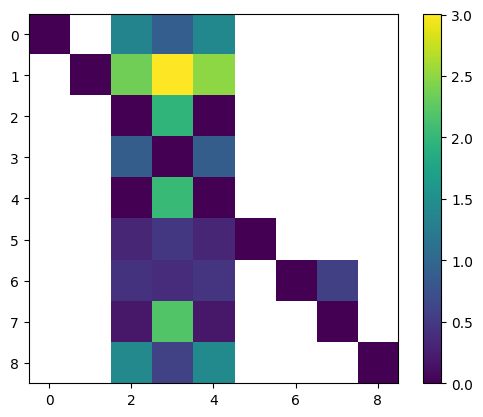

In [50]:
%pip install scipy
from scipy.stats import entropy
import numpy as np
KL = []

i = 0
j = 0

for name, df in standard_df.items():
    row = []
    hist1 = np.histogram(df, bins=bins)[0]
    hist1 = hist1/sum(hist1)
    for name2, df2 in standard_df.items():
        hist2 = np.histogram(df2, bins=bins)[0]
        hist2 = hist2/sum(hist2)
        # print(f'H1: {type(hist1)}, H2: {type(hist2)}')
        row.append(entropy(hist1, hist2))
    KL.append(row)

print(KL)
im = plt.imshow(KL)
plt.colorbar(im)
plt.show()

### Finding KL divergence from mean and std

We assume that each sensors samples comes from a univariate normal distribution with mean $\mu$ and standard deviation $\sigma$, we can estimate $\mu$ and $\sigma$ from the sample date. We can thn find the KL divergence between 2 estimated distributions by the following formula

$$KL(\mathcal{N}_1(\mu_1, \sigma_1)||\mathcal{N}_2(\mu_2, \sigma_2)) = log(\frac{\sigma_2}{\sigma_1}) + \frac{\sigma_1^2 +(\mu_1-\mu_2)^2}{2 \sigma_2^2}-\frac{1}{2}$$

In [51]:
import numpy as np
from scipy.stats import entropy

def KL_with_params(m1, std1, m2, std2):
    return np.log(std2/std1)+(std1**2 + (m1-m2)**2)/(2*std2**2)-1/2

# Test the function
mu, sigma = 1, 2
mu2, sigma2 = 0, 2

print(f'Using mean and std directly: KL={KL_with_params(mu, sigma, mu2, sigma2)}')

Using mean and std directly: KL=0.125


Since this method assumes the mean and standard deviation comes from actual normal distributions, standardizing the samples would make all the sample distributions look identical. We therefore have to us unstandardized values with this KL divergence method. Since it's just estimates of mean and standard deviation, the computed KL divergence will not be the actual KL divergence between the sensors behavior, but rather the KL divergence between the sensors estimated source distributions.

[[0.0, 614630.4735574176, 964.8169699441403, 5211.016828620972, 501.7107544105443, 221.8252783506066, 60814.89432743558, 172.33012850195692, 800.193215003621], [145.3724215164397, 0.0, 308.80080137472817, 868.7532539730412, 508.03695948494936, 8933.765566487058, 671.3434078501707, 53.613583258056295, 822.7479242025262], [58.74542432976195, 80048.78449345543, 0.0, 52.52665001799403, 504.4814826424097, 4290.175398335298, 5248.188086580715, 0.5010444706673258, 813.3064397947538], [72.99075762022795, 51682.22734215924, 12.134790039608385, 0.0, 505.3713579228878, 5067.3245632688895, 2820.4729672810968, 2.651961984984206, 815.3482068251851], [30616526.933096644, 132917047157.74786, 508975962.1636949, 2228676191.0127015, 0.0, 1392810733.1165988, 16047158542.7923, 88549821.69102785, 14917.716994528877], [5.845470491922607, 848132.4382789957, 1562.3298938626872, 8077.531811077268, 503.2421043217655, 0.0, 86529.20049484003, 279.278175748511, 798.8773732402484], [118.61806630875594, 5555.87209938

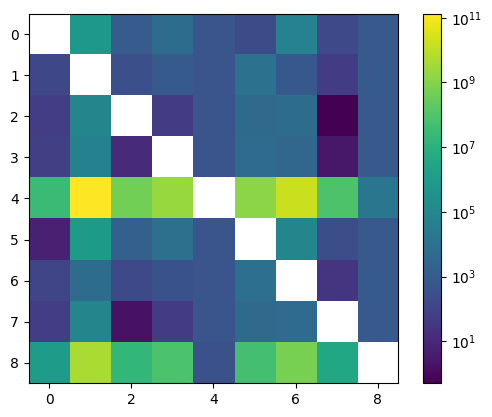

In [52]:
from matplotlib import colors
KL2 = []

for name, df in dfs_dict.items():
    avg1 = df.mean().iloc[0]
    std1 = df.std().iloc[0]
    row = []
    for name, df in dfs_dict.items():
        avg2 = df.mean().iloc[0]
        std2 = df.std().iloc[0]
        kl_tmp = KL_with_params(avg1, std1, avg2, std2)
        row.append(kl_tmp)
    KL2.append(row)

print(KL2)
im = plt.imshow(KL2, norm=colors.LogNorm())
plt.colorbar(im)
plt.show()

### Correlation between sensors

In [54]:
# %pip install jinja2
all_dfs = pd.DataFrame()
for name, df in standard_df.items():
    all_dfs[name] = df.dropna()


corr = all_dfs.corr()
corr.style.background_gradient()



74868


,PDT-92534,PT-92523,TIC-92504,TT 92532,FT-92537,TT-92539,PT-92539,ZT 92543,KA 9101
PDT-92534,1.000000,0.034043,0.358959,-0.037733,0.903134,-0.315973,0.020676,0.381904,0.874132
PT-92523,0.034043,1.000000,-0.010256,-0.155125,-0.385605,-0.079117,0.785034,-0.214074,0.383526
TIC-92504,0.358959,-0.010256,1.000000,-0.126535,0.339280,-0.231804,0.072659,0.481808,0.358990
TT 92532,-0.037733,-0.155125,-0.126535,1.000000,0.075543,0.812969,-0.135532,-0.381984,-0.092587
FT-92537,0.903134,-0.385605,0.339280,0.075543,1.000000,-0.230915,-0.292335,0.409764,0.657602
TT-92539,-0.315973,-0.079117,-0.231804,0.812969,-0.230915,1.000000,-0.102417,-0.370276,-0.326186
PT-92539,0.020676,0.785034,0.072659,-0.135532,-0.292335,-0.102417,1.000000,-0.377185,0.489857
ZT 92543,0.381904,-0.214074,0.481808,-0.381984,0.409764,-0.370276,-0.377185,1.000000,0.135727
KA 9101,0.874132,0.383526,0.358990,-0.092587,0.657602,-0.326186,0.489857,0.135727,1.000000


### Reshape all time series to same length

Original shape: (80790, 1) Resampled shape: (83520, 1)
Original shape: (80786, 1) Resampled shape: (83520, 1)
Original shape: (80757, 1) Resampled shape: (83520, 1)
Original shape: (74868, 1) Resampled shape: (83520, 1)
Original shape: (80920, 1) Resampled shape: (83520, 1)
Original shape: (75647, 1) Resampled shape: (83520, 1)
Original shape: (80782, 1) Resampled shape: (83520, 1)
Original shape: (78333, 1) Resampled shape: (83520, 1)
Original shape: (80659, 1) Resampled shape: (83520, 1)


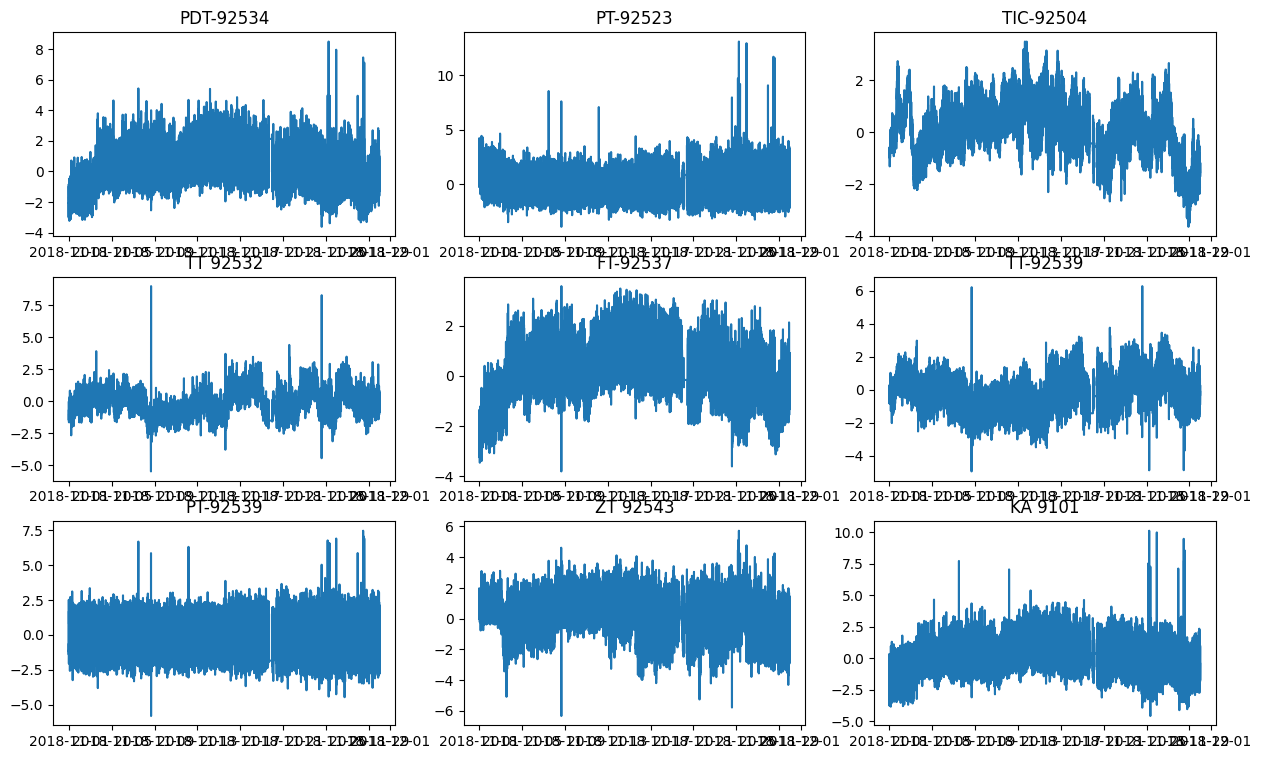

In [62]:
reshape_dfs = {}

for name, df in standard_df.items():
    r_df = df.resample('30S').mean().ffill() #Using ffill to replace Nan with their previous value. "30S" means resample to 1 sample per 30 seconds.
    print(f'Original shape: {df.shape} Resampled shape: {r_df.shape}')
    reshape_dfs[name] = r_df

plot_all_nine_sensors(reshape_dfs)